# Imports & Environment Setup
Initialize libraries, configure display options, and set global constants for a reproducible workflow.

In [1]:
#  Import all core libraries used across the notebook for data analysis, visualization, and modeling.

# Core libraries
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# CatBoost (for gradient boosting)
from catboost import CatBoostClassifier


print(" All core libraries successfully imported .")

 All core libraries successfully imported .


# Data Loading 
Load predictive maintenance data .

In [2]:
# Load Predictive Maintenance Dataset 

FILE_PATH = "predictive_maintenance.xlsx"

# Load the dataset
df = pd.read_excel(FILE_PATH)

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

df.head()

Dataset loaded successfully!
Shape: (12000, 16)
Columns: ['Screen ID', 'Model', 'Resolution', 'Content Type', 'Media Source', 'IP Rating', 'Daily Hours', 'Temperature', 'Reboots per week', 'Humidity_%', 'Status', 'install Type', 'Install year', 'Width_m', 'Height_m', 'rated Power w']


,Screen ID,Model,Resolution,Content Type,Media Source,IP Rating,Daily Hours,Temperature,Reboots per week,Humidity_%,Status,install Type,Install year,Width_m,Height_m,rated Power w
0,O-01935,LED-Indoor,QHD,Mixed,USB,IP43,13.2,30.4,1,22.3,OK,Wall,2020,2.06,2.48,1816
1,W-02494,Interactive-Kiosk,FHD,Animated,USB,IP54,9.1,46.7,0,42.1,WARN,Hanging,2020,0.94,1.73,1256
2,O-01720,Interactive-Kiosk,4K,Static,USB,IP43,12.1,35.6,0,28.4,OK,Wall,2023,1.31,1.18,1513
3,F-01120,LED-Indoor,QHD,Video,Player,IP65,19.5,49.0,5,75.7,FAIL,Hanging,2017,1.36,2.99,1272
4,O-00360,LED-Indoor,FHD,Video,Player,IP66,9.7,36.4,1,47.9,OK,Hanging,2019,2.37,2.51,2781


# Data Quality & Basic Cleaning
Assess data health, coerce numeric types, and impute missing values to produce df_clean for downstream feature engineering.

In [3]:
#  Data Quality HUD + basic cleaning (
from datetime import datetime



# 1) Standardize column names to snake_case (safe ASCII)
def to_snake(cols):
    out = []
    for c in cols:
        s = (str(c)
             .replace("%","pct").replace("/","_per_"))
        s = ''.join(ch if (ch.isalnum() or ch==' ') else ' ' for ch in s)
        s = '_'.join(s.lower().split())
        out.append(s)
    return out

df_full = df.copy()
df_full.columns = to_snake(df_full.columns)



# 2) Quick HUD
def hud(df: pd.DataFrame, key_cols=None, head_n=5):
    print(f"\n===== HUD =====")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} cols")
    miss = df.isna().sum().sort_values(ascending=False)
    print("\nTop missing (non-zero):")
    display(miss[miss>0].head(15))
    print("\nDtypes:")
    display(df.dtypes)
    if key_cols:
        print("\nUnique counts (key cols):")
        display(df[key_cols].nunique())

key_cols = [c for c in ['screen_id','status','model','install_type','location_city'] if c in df_full.columns]
hud(df_full, key_cols=key_cols)

# 3) Coerce numerics
num_like = [c for c in [
    'daily_hours','temperature','reboots_per_week','humidity_pct',
    'height_m','width_m','rated_power_w','install_year'
] if c in df_full.columns]

for c in num_like:
    df_full[c] = pd.to_numeric(df_full[c], errors='coerce')



# 4) Basic imputation
num_cols = [c for c in df_full.columns if df_full[c].dtype.kind in "if"]
cat_cols = [c for c in df_full.columns if c not in num_cols]

df_clean = df_full.copy()
for c in num_cols:
    med = df_clean[c].median()
    df_clean[c] = df_clean[c].fillna(med)

for c in cat_cols:
    df_clean[c] = df_clean[c].fillna("Unknown")

# 5) Label sanity check
if 'status' in df_clean.columns:
    print("\nLabel distribution (status):")
    display(df_clean['status'].value_counts(normalize=True).rename('proportion'))

print("\n df_clean is ready for feature engineering.")


print("Shape after dropping:", df_clean.shape)
print("Remaining columns in df_clean:", df_clean.columns.tolist())


===== HUD =====
Shape: 12,000 rows × 16 cols

Top missing (non-zero):


Series([], dtype: int64)


Dtypes:


screen_id            object
model                object
resolution           object
content_type         object
media_source         object
ip_rating            object
daily_hours         float64
temperature         float64
reboots_per_week      int64
humidity_pct        float64
status               object
install_type         object
install_year          int64
width_m             float64
height_m            float64
rated_power_w         int64
dtype: object


Unique counts (key cols):


screen_id       12000
status              3
model               6
install_type        4
dtype: int64


Label distribution (status):


status
OK      0.333333
WARN    0.333333
FAIL    0.333333
Name: proportion, dtype: float64


 df_clean is ready for feature engineering.
Shape after dropping: (12000, 16)
Remaining columns in df_clean: ['screen_id', 'model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'status', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w']


# Weather Data Inspection (Raw Files Overview)
 Inspect structure & first rows of annual Hail weather datasets (2022–2024)

In [4]:
import pandas as pd

for f in ["weather_hail_2022.csv", "weather_hail_2023.csv", "weather_hail_2024.csv"]:
    df = pd.read_csv(f)
    print(f"\n=== {f} ===")
    print(df.columns.tolist())
    print(df.head(2))


=== weather_hail_2022.csv ===
['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']
                 name    datetime  tempmax  tempmin  temp  feelslikemax  \
0  Hail, Saudi Arabia  2022-01-01     66.2     46.2  54.9          66.2   
1  Hail, Saudi Arabia  2022-01-02     60.8     50.0  54.3          60.8   

   feelslikemin  feelslike   dew  humidity  ...  solarenergy  uvindex  \
0          45.4       54.8  47.9      78.6  ...         10.7        6   
1          50.0       54.3  47.7      80.8  ...         14.2        7   

   severerisk              sunrise               sunset  moonphase  \
0         NaN  2022-01-01T07:03:41  202

# Synthetic Month Assignment
 Add probabilistic install_month feature using weighted random sampling for seasonal modeling

In [5]:
# Synthetic Month Assignment 

import numpy as np
import pandas as pd


df_pm_m = df_clean.copy()


rng = np.random.default_rng(42)

months = np.arange(1, 13)


weights = np.array([0.06, 0.06, 0.07, 0.08, 0.10, 0.10, 0.10, 0.10, 0.09, 0.08, 0.08, 0.08])
weights = weights / weights.sum()


df_pm_m["install_month"] = rng.choice(months, size=len(df_pm_m), p=weights)

print("install_month assigned in-memory.")
print("Rows:", len(df_pm_m), "Cols:", len(df_pm_m.columns))
print("Columns preview:", list(df_pm_m.columns))

install_month assigned in-memory.
Rows: 12000 Cols: 17
Columns preview: ['screen_id', 'model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'status', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w', 'install_month']


## Monthly Weather Merge & Feature Rebuild  
Load Hail weather records (2022–2024), aggregate them monthly, merge with the maintenance data using install_year/install_month, then rebuild df_fe and X_tab with the new weather-aware features.

In [6]:


# Load and concat weather (must exist in the working dir)
w22 = pd.read_csv("weather_hail_2022.csv")
w23 = pd.read_csv("weather_hail_2023.csv")
w24 = pd.read_csv("weather_hail_2024.csv")
df_weather = pd.concat([w22, w23, w24], ignore_index=True)

# Normalize date → year, month
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])
df_weather["year"]  = df_weather["datetime"].dt.year
df_weather["month"] = df_weather["datetime"].dt.month

def is_hot(row, thr_f=95):
    return 1 if row.get("tempmax", np.nan) >= thr_f else 0

def is_rain(row):
    cond = row.get("conditions", "")
    return 1 if isinstance(cond, str) and "Rain" in cond else 0

df_weather["is_hot"]  = df_weather.apply(is_hot, axis=1)
df_weather["is_rain"] = df_weather.apply(is_rain, axis=1)

monthly = (
    df_weather
    .groupby(["year", "month"])
    .agg(
        avg_temp   = ("temp", "mean"),
        avg_hum    = ("humidity", "mean"),
        avg_wind   = ("windspeed", "mean"),
        total_precip = ("precip", "sum"),
        hot_days   = ("is_hot", "sum"),
        rainy_days = ("is_rain", "sum"),
        avg_uv     = ("uvindex", "mean"),
        avg_cloud  = ("cloudcover", "mean"),
    )
    .reset_index()
)

print("Monthly weather sample:")
print(monthly.head())


df_pm_m["install_year"]  = pd.to_numeric(df_pm_m["install_year"], errors="coerce")
df_pm_m["install_month"] = pd.to_numeric(df_pm_m["install_month"], errors="coerce").clip(1, 12)

yr_min, yr_max = int(monthly["year"].min()), int(monthly["year"].max())
df_pm_m["year_for_merge"]  = df_pm_m["install_year"].round().clip(yr_min, yr_max)
df_pm_m["month_for_merge"] = df_pm_m["install_month"].round().clip(1, 12).astype(int)

df_merged = df_pm_m.merge(
    monthly,
    left_on=["year_for_merge", "month_for_merge"],
    right_on=["year", "month"],
    how="left"
).drop(columns=["year", "month"])

print("\nColumns after merge:")
print(df_merged.columns.tolist())

if "avg_temp" in df_merged.columns:
    match_rate = df_merged["avg_temp"].notna().mean()
    print(f"\nMerge done. Match-rate = {match_rate:.3f}")
else:
    print("\nMerge done. Note: 'avg_temp' column not found. Available weather columns:")
    print([c for c in df_merged.columns if c.startswith(("avg_", "total_", "hot_", "rainy_"))])

print("Preview:")
print(df_merged.head())

# ===== Rebuild df_fe AFTER weather merge =====
df_fe = df_merged.copy()
# 1) Simple engineered features
this_year = datetime.now().year
if 'install_year' in df_fe.columns:
    df_fe['age_years'] = (this_year - df_fe['install_year']).clip(lower=0)

if {'height_m','width_m'}.issubset(df_fe.columns):
    df_fe['area_m2'] = df_fe['height_m'] * df_fe['width_m']
else:
    df_fe['area_m2'] = np.nan

if 'daily_hours' in df_fe.columns:
    df_fe['weekly_hours'] = (df_fe['daily_hours'] * 7).clip(0, 168)
else:
    df_fe['weekly_hours'] = np.nan

if {'rated_power_w','weekly_hours'}.issubset(df_fe.columns):
    df_fe['weekly_energy_Wh'] = df_fe['rated_power_w'] * df_fe['weekly_hours']
else:
    df_fe['weekly_energy_Wh'] = np.nan

# 2) Environmental interactions
if {'temperature','humidity_pct'}.issubset(df_fe.columns):
    df_fe['temp_x_humidity'] = df_fe['temperature'] * (df_fe['humidity_pct']/100.0)

# 3) Target
if 'status' in df_fe.columns:
    df_fe['y_multi'] = df_fe['status'].map({'OK':'OK','WARN':'WARN','FAIL':'FAIL'}).fillna('OK')
else:
    raise AssertionError("status column not found.")

# 4) Build X_all
drop_cols = [c for c in ['screen_id','status','y_multi','y_bin'] if c in df_fe.columns]
X_all = df_fe.drop(columns=drop_cols, errors='ignore')

# 5) One hot encoding
cat_cols = [c for c in X_all.columns if X_all[c].dtype == 'object']
X_tab = pd.get_dummies(X_all, columns=cat_cols, drop_first=False)

y_multi = df_fe['y_multi'].reset_index(drop=True)
X_tab    = X_tab.reset_index(drop=True)

m = min(len(X_tab), len(y_multi))
X_tab  = X_tab.iloc[:m].copy()
y_multi = y_multi.iloc[:m].copy()

print(" Feature engineering rebuilt successfully")
print("X_tab shape:", X_tab.shape)

Monthly weather sample:
   year  month   avg_temp    avg_hum   avg_wind  total_precip  hot_days  \
0  2022      1  52.312903  53.609677  14.916129         0.625         0   
1  2022      2  57.021429  36.060714  16.760714         0.039         0   
2  2022      3  63.796774  24.496774  17.374194         0.012         0   
3  2022      4  76.833333  23.193333  15.260000         0.857         5   
4  2022      5  83.693548  14.941935  15.441935         0.004        16   

   rainy_days     avg_uv  avg_cloud  
0           6   7.000000  21.077419  
1           1   8.178571   9.757143  
2           3   9.290323  21.109677  
3           7   9.800000  32.676667  
4           1  10.000000   2.887097  

Columns after merge:
['screen_id', 'model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'status', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w', 'install_month', 'year_for_merge', 'month_for

#  Missing-Value Verification
 Confirm that X_tab and y_multi contain no remaining NaN values after cleaning and encoding.

In [7]:

#  Inspect engineered dataframe (df_fe) 
import pandas as pd

print(" DataFrame shape:", df_fe.shape)
print("\n Column overview:\n")

col_summary = (
    df_fe.isna().sum()
    .to_frame("missing_values")
    .join(df_fe.dtypes.rename("dtype"))
    .assign(non_missing=lambda x: len(df_fe) - x["missing_values"])
    .assign(missing_pct=lambda x: (x["missing_values"]/len(df_fe)*100).round(2))
)

display(col_summary.sort_values("missing_values", ascending=False))

missing_cols = col_summary[col_summary["missing_values"] > 0]
if not missing_cols.empty:
    print("\n Columns that contain missing values:")
    display(missing_cols)
else:
    print("\n No missing values detected in df_fe.")

print("\n Sample of data:")
display(df_fe.head())

 DataFrame shape: (12000, 33)

 Column overview:



,missing_values,dtype,non_missing,missing_pct
screen_id,0,object,12000,0.0
model,0,object,12000,0.0
resolution,0,object,12000,0.0
content_type,0,object,12000,0.0
media_source,0,object,12000,0.0
ip_rating,0,object,12000,0.0
daily_hours,0,float64,12000,0.0
temperature,0,float64,12000,0.0
reboots_per_week,0,int64,12000,0.0
humidity_pct,0,float64,12000,0.0



 No missing values detected in df_fe.

 Sample of data:


,screen_id,model,resolution,content_type,media_source,ip_rating,daily_hours,temperature,reboots_per_week,humidity_pct,...,hot_days,rainy_days,avg_uv,avg_cloud,age_years,area_m2,weekly_hours,weekly_energy_Wh,temp_x_humidity,y_multi
0,O-01935,LED-Indoor,QHD,Mixed,USB,IP43,13.2,30.4,1,22.3,...,9,1,8.322581,9.925806,5,5.1088,92.4,167798.4,6.7792,OK
1,W-02494,Interactive-Kiosk,FHD,Animated,USB,IP54,9.1,46.7,0,42.1,...,30,0,10.000000,6.206667,5,1.6262,63.7,80007.2,19.6607,WARN
2,O-01720,Interactive-Kiosk,4K,Static,USB,IP43,12.1,35.6,0,28.4,...,0,10,6.866667,29.923333,2,1.5458,84.7,128151.1,10.1104,OK
3,F-01120,LED-Indoor,QHD,Video,Player,IP65,19.5,49.0,5,75.7,...,24,0,9.300000,6.743333,8,4.0664,136.5,173628.0,37.0930,FAIL
4,O-00360,LED-Indoor,FHD,Video,Player,IP66,9.7,36.4,1,47.9,...,0,1,8.178571,9.757143,6,5.9487,67.9,188829.9,17.4356,OK


# Sanity Checks & Train–Test Split
 Check duplicate screen IDs, inspect top numeric correlations, and create a stratified 80/20 train–test split

In [8]:
# === PM4: Sanity checks (duplicates, leakage, splits preview) ===
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

assert all(k in globals() for k in ['X_tab','y_multi'])

# 1) Duplicates on Screen_ID if available
if 'screen_id' in df_clean.columns:
    dup = df_clean.duplicated(subset=['screen_id']).sum()
    print(f"Duplicate screen_id rows: {dup}")
else:
    print("screen_id not present – skip duplicate check.")

# 2) Quick correlation peek (numerics only; for leakage hints)
num_cols = [c for c in X_tab.columns if X_tab[c].dtype.kind in "if"]
corr = X_tab[num_cols].corr().abs().stack().reset_index()
corr = corr[corr['level_0']<corr['level_1']].sort_values(0, ascending=False).head(10)
print("\nTop numeric correlations (absolute):")
display(corr.rename(columns={'level_0':'feat_a','level_1':'feat_b',0:'|corr|'}))

# 3) Hold-out split preview (binary target)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_tab, y_multi, test_size=0.20, random_state=42, stratify=y_multi
)
print(f"\nSplit → TRAIN: {X_tr.shape}, TEST: {X_te.shape}")
print("TRAIN class balance:")
display(y_tr.value_counts(normalize=True).rename('proportion'))
print("TEST class balance:")
display(y_te.value_counts(normalize=True).rename('proportion'))

print("\n clean split objects ready (X_tr, X_te, y_tr, y_te).")

Duplicate screen_id rows: 0

Top numeric correlations (absolute):


,feat_a,feat_b,|corr|
21,daily_hours,weekly_hours,1.000000
460,age_years,install_year,1.000000
202,install_month,month_for_merge,1.000000
279,avg_temp,hot_days,0.940762
305,avg_hum,avg_uv,0.938543
95,humidity_pct,temp_x_humidity,0.929702
448,avg_cloud,rainy_days,0.905048
398,rainy_days,total_precip,0.902405
190,rated_power_w,weekly_energy_Wh,0.877843
304,avg_hum,rainy_days,0.858569



Split → TRAIN: (9600, 49), TEST: (2400, 49)
TRAIN class balance:


y_multi
WARN    0.333333
FAIL    0.333333
OK      0.333333
Name: proportion, dtype: float64

TEST class balance:


y_multi
FAIL    0.333333
OK      0.333333
WARN    0.333333
Name: proportion, dtype: float64


 clean split objects ready (X_tr, X_te, y_tr, y_te).



# Column Overview & Feature Matrix Inspection
 Compare columns across df_full, df_fe, and X_all to ensure correct cleaning and feature construction

In [9]:
print("df_full cols:", list(df_full.columns)[:20], "...", len(df_full.columns))
print("df_fe   cols:", list(df_fe.columns)[:20],   "...", len(df_fe.columns))
print("X_all  cols:",  list(X_all.columns)[:20],   "...", len(X_all.columns))

df_full cols: ['screen_id', 'model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'status', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w'] ... 16
df_fe   cols: ['screen_id', 'model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'status', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w', 'install_month', 'year_for_merge', 'month_for_merge', 'avg_temp'] ... 33
X_all  cols: ['model', 'resolution', 'content_type', 'media_source', 'ip_rating', 'daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'install_type', 'install_year', 'width_m', 'height_m', 'rated_power_w', 'install_month', 'year_for_merge', 'month_for_merge', 'avg_temp', 'avg_hum', 'avg_wind'] ... 30


# Redundant Feature Removal
 Drop highly correlated or redundant engineered features to reduce noise before modeling

In [10]:
# Remove redundant correlated columns
df_fe = df_fe.drop(columns=['weekly_hours', 'weekly_energy_Wh', 'age_years',])

print(" Columns removed successfully.")
print(" New shape:", df_full.shape)

 Columns removed successfully.
 New shape: (12000, 16)


# Exploratory Distributions of Key Sensor & Usage Features
 Visualize core numerical variables to understand usage patterns and environmental conditions

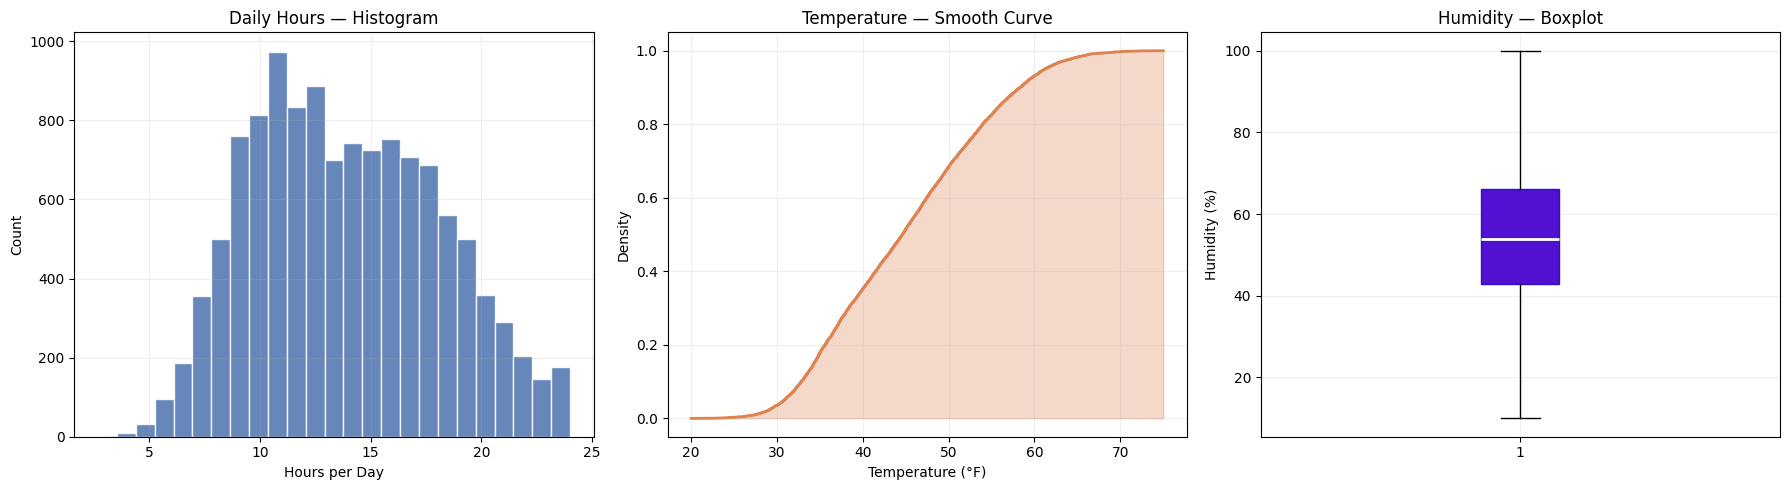

In [11]:

import matplotlib.pyplot as plt

assert 'df_fe' in globals()

plt.figure(figsize=(18,5))

# 1) Histogram (Daily Hours)
plt.subplot(1,3,1)
if 'daily_hours' in df_full.columns:
    s = df_full['daily_hours'].dropna()
    plt.hist(s, bins=25, color="#4C72B0", edgecolor="white", alpha=0.85)
    plt.title("Daily Hours — Histogram", fontsize=12)
    plt.xlabel("Hours per Day")
    plt.ylabel("Count")
    plt.grid(alpha=0.2)
else:
    plt.text(0.5,0.5,"Missing: daily_hours", ha='center')

# 2) KDE-style smooth plot (Temperature)
plt.subplot(1,3,2)
if 'temperature' in df_full.columns:
    s = df_full['temperature'].dropna()
    s_sorted = np.sort(s)
    density = np.linspace(0, 1, len(s_sorted))
    plt.plot(s_sorted, density, color="#DD8452", linewidth=2)
    plt.fill_between(s_sorted, density, alpha=0.3, color="#DD8452")
    plt.title("Temperature — Smooth Curve", fontsize=12)
    plt.xlabel("Temperature (°F)")
    plt.ylabel("Density")
    plt.grid(alpha=0.2)
else:
    plt.text(0.5,0.5,"Missing: temperature", ha='center')

# 3) Boxplot (Humidity)
plt.subplot(1,3,3)
if 'humidity_pct' in df_full.columns:
    s = df_full['humidity_pct'].dropna()
    plt.boxplot(s, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#5111D1", color="#2D11CA"),
                medianprops=dict(color="white", linewidth=2))
    plt.title("Humidity — Boxplot", fontsize=12)
    plt.ylabel("Humidity (%)")
    plt.grid(alpha=0.2)
else:
    plt.text(0.5,0.5,"Missing: humidity_pct", ha='center')

plt.tight_layout()
plt.show()

# Refined Status-Based Analysis
#Visualizing class balance, usage behavior, and environmental relations

C:\Users\hlaa7\AppData\Local\Temp\ipykernel_22360\106789931.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


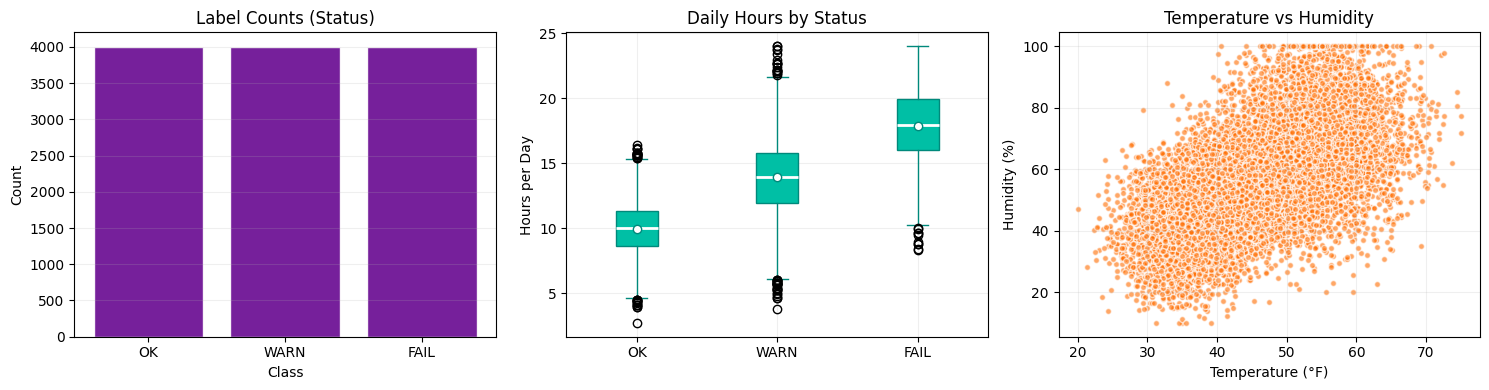

In [12]:
#  Class balance, Boxplot by Status, Scatter 
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

# (A) Class balance bar
plt.subplot(1,3,1)
if 'status' in df_full.columns:
    vc = df_fe['status'].value_counts(dropna=False)

    plt.bar(vc.index, vc.values, color="#670890", edgecolor="white", alpha=0.9)
    plt.title("Label Counts (Status)", fontsize=12)
    plt.xlabel("Class"); 
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.2)
else:
    plt.text(0.5,0.5,"Missing: status", ha='center', va='center')

# (B) Boxplot Daily_Hours by Status
plt.subplot(1,3,2)
if {'status','daily_hours'}.issubset(df_full.columns):
    cats = df_fe['status'].dropna().unique().tolist()
    data = [df_fe.loc[df_full['status']==c,'daily_hours'].dropna() for c in cats]

    if len(data)>0:
        plt.boxplot(
            data, labels=cats, showmeans=True,
            patch_artist=True,
            boxprops=dict(facecolor="#00BFA5", color="#00897B"),
            medianprops=dict(color="white", linewidth=2),
            whiskerprops=dict(color="#00897B"),
            capprops=dict(color="#00897B"),
            meanprops=dict(marker='o', markerfacecolor="white", markeredgecolor="#00897B")
        )
        plt.title("Daily Hours by Status", fontsize=12)
        plt.ylabel("Hours per Day")
        plt.grid(alpha=0.2)
    else:
        plt.text(0.5,0.5,"No data", ha='center', va='center')
else:
    plt.text(0.5,0.5,"Need: status + daily_hours", ha='center', va='center')

# (C) Scatter: Temperature vs Humidity
plt.subplot(1,3,3)
if {'temperature','humidity_pct'}.issubset(df_full.columns):
    samp = df_fe[['temperature','humidity_pct']].dropna()

    if len(samp):
        plt.scatter(
            samp['temperature'], 
            samp['humidity_pct'], 
            s=18, alpha=0.6, color="#FF6D00", edgecolors="white"
        )
        plt.title("Temperature vs Humidity", fontsize=12)
        plt.xlabel("Temperature (°F)")
        plt.ylabel("Humidity (%)")
        plt.grid(alpha=0.2)
    else:
        plt.text(0.5,0.5,"No data", ha='center', va='center')
else:
    plt.text(0.5,0.5,"Need: temperature + humidity_pct", ha='center', va='center')

plt.tight_layout()
plt.show()

# Advanced Relationship Analysis
 Exploring correlations, usage patterns, and power behavior across status levels

C:\Users\hlaa7\AppData\Local\Temp\ipykernel_22360\1197160173.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(
C:\Users\hlaa7\AppData\Local\Temp\ipykernel_22360\1197160173.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


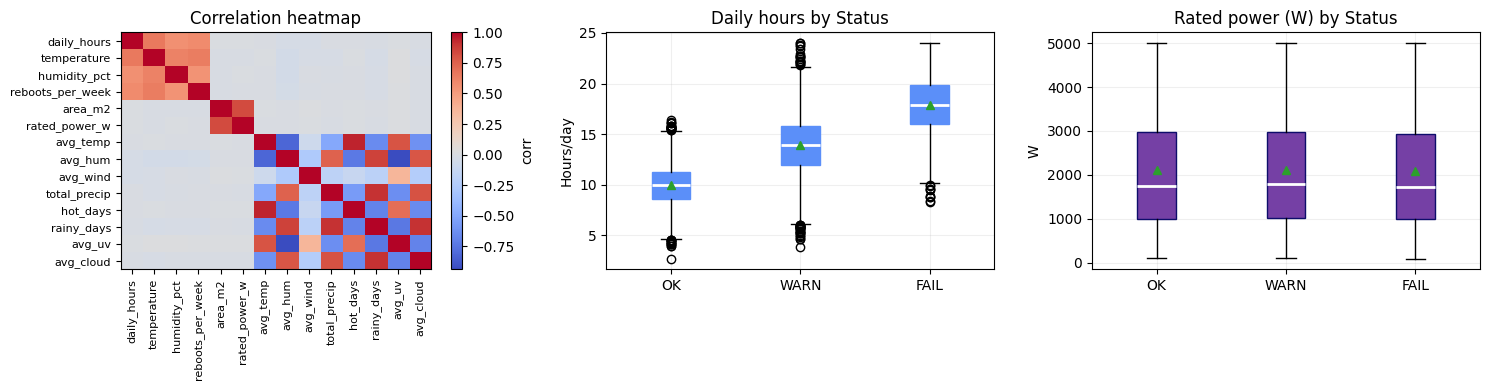

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DF = df_fe.copy()

plt.figure(figsize=(15, 4))

# (A) Correlation heatmap
num_whitelist = [
    'daily_hours', 'temperature', 'humidity_pct', 'reboots_per_week',
    'area_m2', 'rated_power_w',
    'avg_temp', 'avg_hum', 'avg_wind', 'total_precip',
    'hot_days', 'rainy_days', 'avg_uv', 'avg_cloud'
]
num_cols = [c for c in num_whitelist if c in DF.columns and pd.api.types.is_numeric_dtype(DF[c])]

plt.subplot(1, 3, 1)
if len(num_cols) >= 2:
    corr = DF[num_cols].corr()
    plt.imshow(corr, aspect='auto', cmap="coolwarm")   # Heatmap colors
    plt.colorbar(label='corr')
    plt.title("Correlation heatmap")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=8)
    plt.yticks(range(len(num_cols)), num_cols, fontsize=8)
else:
    plt.text(0.5, 0.5, "Not enough numeric cols", ha='center', va='center')


# (B) Daily hours by Status — Boxplot 
plt.subplot(1, 3, 2)
if {'status', 'daily_hours'}.issubset(DF.columns):
    cats = DF['status'].dropna().unique().tolist()
    data = [DF.loc[DF['status'] == c, 'daily_hours'].dropna() for c in cats]
    if any(len(d) for d in data):
        plt.boxplot(
            data, 
            labels=cats, 
            showmeans=True,
            patch_artist=True,
            boxprops=dict(facecolor="#5B8FF9", color="#5B8FF9"),
            medianprops=dict(color="white", linewidth=2),
            meanprops=dict(color="yellow")
        )
        plt.title("Daily hours by Status")
        plt.ylabel("Hours/day")
        plt.grid(alpha=0.2)
    else:
        plt.text(0.5, 0.5, "No data", ha='center', va='center')
else:
    plt.text(0.5, 0.5, "Need: status + daily_hours", ha='center', va='center')


# (C) Rated power by Status — Boxplot 
plt.subplot(1, 3, 3)
if {'status', 'rated_power_w'}.issubset(DF.columns):
    cats = DF['status'].dropna().unique().tolist()
    data = [DF.loc[DF['status'] == c, 'rated_power_w'].dropna() for c in cats]
    if any(len(d) for d in data):
        plt.boxplot(
            data, 
            labels=cats, 
            showmeans=True,
            patch_artist=True,
            boxprops=dict(facecolor="#7540A5", color="#0E0D6B"),
            medianprops=dict(color="white", linewidth=2),
            meanprops=dict(color="yellow")
        )
        plt.title("Rated power (W) by Status")
        plt.ylabel("W")
        plt.grid(alpha=0.2)
    else:
        plt.text(0.5, 0.5, "No data", ha='center', va='center')
else:
    plt.text(0.5, 0.5, "Need: status + rated_power_w", ha='center', va='center')

plt.tight_layout()
plt.show()

# Missing Values Verification  
 Ensuring that no NaN values remain after cleaning

In [14]:

assert 'X_tab' in globals() and 'y_multi' in globals()

print("Total NaNs in X_tab:", int(X_tab.isna().sum().sum()))

print("Total NaNs in y_multi:", int(pd.Series(y_multi).isna().sum()))

if X_tab.isna().any().any():
    print("\nTop columns with missing values:")
    display(X_tab.isna().sum().sort_values(ascending=False).head(10))

Total NaNs in X_tab: 0
Total NaNs in y_multi: 0


# Encoded Dataset Overview
 Summary of dataset structure after One-Hot Encoding

In [15]:

print("X_tab shape:", X_tab.shape)

print("\nData types summary:")
display(X_tab.dtypes.value_counts())

print("\nSample of encoded columns:")
print(X_tab.columns[:15].tolist())

X_tab shape: (12000, 49)

Data types summary:


bool       25
float64    15
int64       9
Name: count, dtype: int64


Sample of encoded columns:
['daily_hours', 'temperature', 'reboots_per_week', 'humidity_pct', 'install_year', 'width_m', 'height_m', 'rated_power_w', 'install_month', 'year_for_merge', 'month_for_merge', 'avg_temp', 'avg_hum', 'avg_wind', 'total_precip']


# Baseline Model Training, Performance Evaluation, and Class-Level Analysis
 Comparing Logistic Regression, Random Forest, and CatBoost on Multiclass Failure Prediction

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=8000, solver="newton-cg", multi_class="auto"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, verbose=False, random_seed=42),
}

classes = np.unique(y_te)
results = []

for name, model in models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)

    acc = accuracy_score(y_te, preds)
    f1  = f1_score(y_te, preds, average="macro")
    results.append((name, acc, f1))

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} | F1 (macro): {f1:.3f}")

    cm = confusion_matrix(y_te, preds, labels=classes)
    df_cm = pd.DataFrame(
        cm,
        index=[f"Actual {c}" for c in classes],
        columns=[f"Pred {c}" for c in classes],
    )
    display(df_cm)

    print("\nClassification Report:")
    print(classification_report(y_te, preds, labels=classes, target_names=[str(c) for c in classes], zero_division=0))

df_results = pd.DataFrame(results, columns=["Model","Accuracy","F1_macro"]).sort_values("F1_macro", ascending=False)
print("\n=== Model Comparison Summary ===")
display(df_results)

c:\Users\hlaa7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy: 0.938 | F1 (macro): 0.937


,Pred FAIL,Pred OK,Pred WARN
Actual FAIL,758,0,42
Actual OK,0,771,29
Actual WARN,45,34,721



Classification Report:
              precision    recall  f1-score   support

        FAIL       0.94      0.95      0.95       800
          OK       0.96      0.96      0.96       800
        WARN       0.91      0.90      0.91       800

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400


=== Random Forest ===
Accuracy: 0.943 | F1 (macro): 0.943


,Pred FAIL,Pred OK,Pred WARN
Actual FAIL,755,0,45
Actual OK,0,775,25
Actual WARN,39,27,734



Classification Report:
              precision    recall  f1-score   support

        FAIL       0.95      0.94      0.95       800
          OK       0.97      0.97      0.97       800
        WARN       0.91      0.92      0.92       800

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400


=== CatBoost ===
Accuracy: 0.944 | F1 (macro): 0.944


,Pred FAIL,Pred OK,Pred WARN
Actual FAIL,750,0,50
Actual OK,0,781,19
Actual WARN,36,29,735



Classification Report:
              precision    recall  f1-score   support

        FAIL       0.95      0.94      0.95       800
          OK       0.96      0.98      0.97       800
        WARN       0.91      0.92      0.92       800

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400


=== Model Comparison Summary ===


,Model,Accuracy,F1_macro
2,CatBoost,0.944167,0.944140
1,Random Forest,0.943333,0.943352
0,Logistic Regression,0.937500,0.937418


# Final Model Assignment
 Storing the trained models for reuse

In [17]:
lr_final = models["Logistic Regression"]
rf_final = models["Random Forest"]
cb_final = models["CatBoost"]

print("\n Models saved in memory as: lr_final, rf_final, cb_final (ready for reuse)")


 Models saved in memory as: lr_final, rf_final, cb_final (ready for reuse)


# Learning Curves for All Models
 Checking how train and validation accuracy change as training size increases

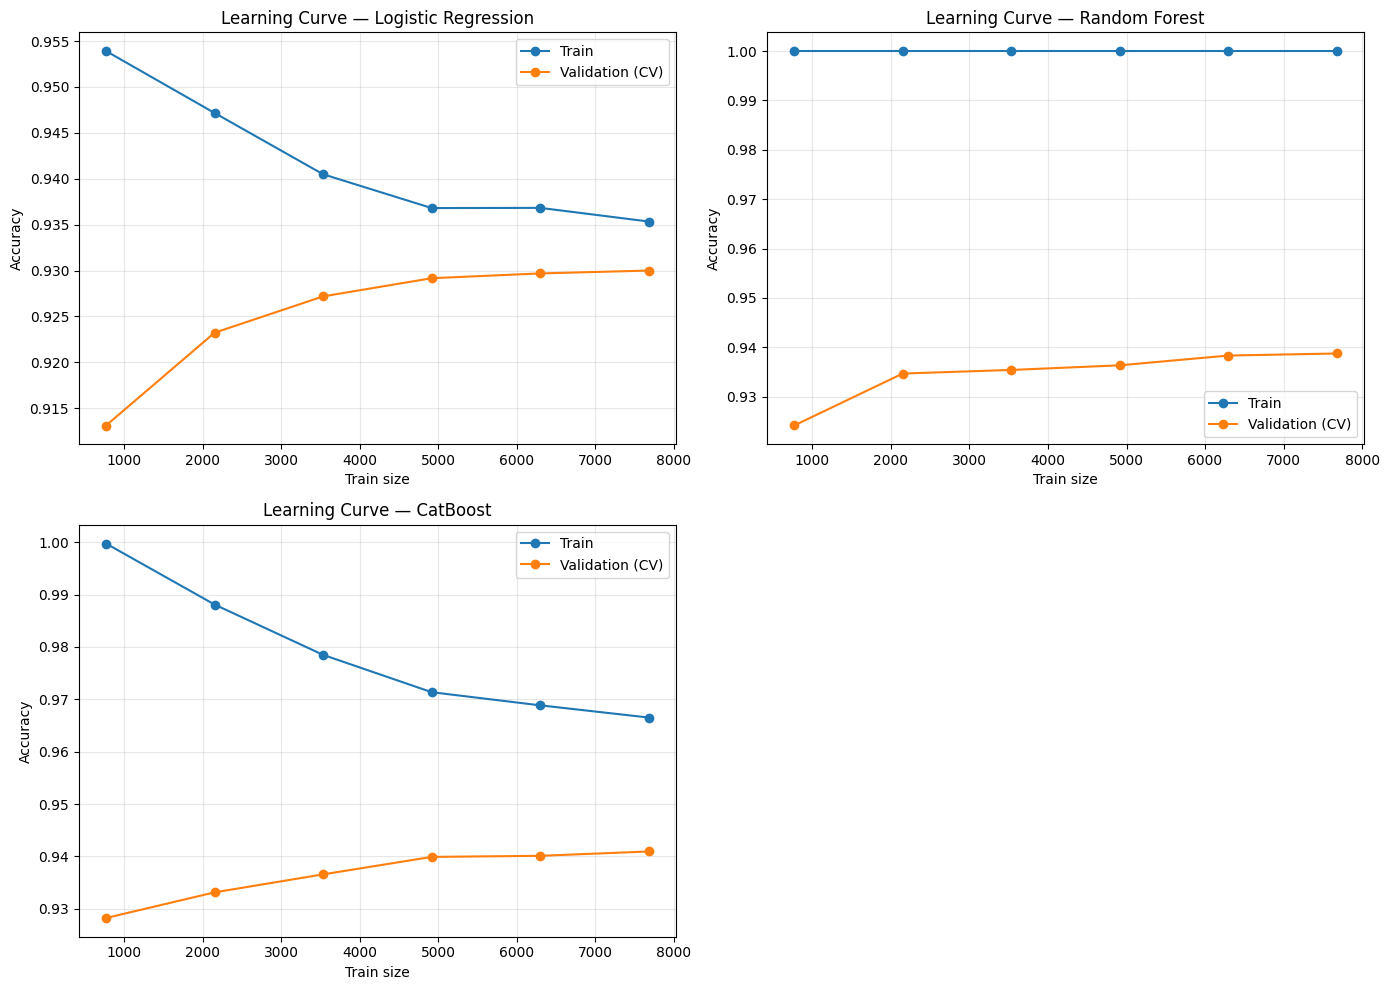

In [18]:
# Learning Curves for all models
from sklearn.model_selection import learning_curve
import numpy as np, matplotlib.pyplot as plt
from sklearn.base import clone


models_all = {}
for name_var, pretty in [("lr_final","Logistic Regression"),
                         ("rf_final","Random Forest"),
                         ("cb_final","CatBoost")]:
    if name_var in globals():
        models_all[pretty] = globals()[name_var]

# Fallback: use 'models' dict (from your baseline cell) if not present
if not models_all and 'models' in globals():
    models_all = globals()['models']

if not models_all:
    raise RuntimeError("No models found. Make sure you have trained models or a 'models' dict.")

plt.figure(figsize=(14,10))
rows = int(np.ceil(len(models_all)/2))
cols = 2 if len(models_all)>1 else 1

for i,(name, mdl) in enumerate(models_all.items(), start=1):
    plt.subplot(rows, cols, i)
    # Use a fresh clone for learning_curve (it trains internally)
    est = clone(mdl)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=est, X=X_tr, y=y_tr,
        cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=-1
    )
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='Validation (CV)')
    plt.title(f'Learning Curve — {name}')
    plt.xlabel('Train size'); plt.ylabel('Accuracy'); plt.grid(True, alpha=.3); plt.legend()

plt.tight_layout(); plt.show()

# Confidence Gap Analysis
 Comparing average prediction confidence between Train and Test sets

In [19]:
# Confidence Gap for all models (Train vs Test)
import numpy as np

def max_confidence(model, X):
    # Prefer predict_proba; fallback to decision_function scaled to [0,1]
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X).max(axis=1)
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X)
        # normalize to [0,1]
        if s.ndim == 1:
          
            return 1/(1+np.exp(-s))
        else:
            # multiclass margins -> softmax
            e = np.exp(s - s.max(axis=1, keepdims=True))
            p = e / e.sum(axis=1, keepdims=True)
            return p.max(axis=1)
    else:
       
        preds = model.predict(X)
      
        return np.ones(len(preds))

for name, mdl in models_all.items():
    conf_tr = max_confidence(mdl, X_tr).mean()
    conf_te = max_confidence(mdl, X_te).mean()
    print(f"{name} → Mean confidence Train={conf_tr:.3f}, Test={conf_te:.3f}, Gap={conf_tr-conf_te:+.3f}")

Logistic Regression → Mean confidence Train=0.933, Test=0.937, Gap=-0.004
Random Forest → Mean confidence Train=0.950, Test=0.888, Gap=+0.061
CatBoost → Mean confidence Train=0.942, Test=0.943, Gap=-0.001


# Time-Based Holdout Evaluation  
 Assessing model generalization across installation years

In [20]:
# Time-based Holdout (train<=2023, test=2024) for all models
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score

if 'df_fe' in globals() and 'install_year' in df_fe.columns:
    yrs = df_fe['install_year'].reset_index(drop=True)
    mask_tr = (yrs <= 2023)
    mask_te = (yrs == 2024)

    if mask_tr.sum()>0 and mask_te.sum()>0:
        X_time_tr, y_time_tr = X_tab[mask_tr], y_multi[mask_tr]
        X_time_te, y_time_te = X_tab[mask_te], y_multi[mask_te]

        for name, mdl in models_all.items():
            m = clone(mdl)
            m.fit(X_time_tr, y_time_tr)
            preds = m.predict(X_time_te)
            acc = accuracy_score(y_time_te, preds)
            print(f"{name} (Time-holdout 2024) → Acc={acc:.3f}")
    else:
        print("Not enough data for a 2024 time-holdout split.")
else:
    print("install_year not available in df_fe; skipping time-based holdout.")

c:\Users\hlaa7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\hlaa7\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\hlaa7\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Logistic Regression (Time-holdout 2024) → Acc=0.942
Random Forest (Time-holdout 2024) → Acc=0.946
CatBoost (Time-holdout 2024) → Acc=0.963


#  Save Final Model
Export the fully trained pipeline for deployment in backend prediction.

In [21]:
# ===== Save the final CatBoost model for later use =====
import joblib, json


model_path = "final_catboost_model.pkl"
feat_path  = "catboost_features.json"


joblib.dump(models["CatBoost"], model_path)
json.dump(list(X_tab.columns), open(feat_path, "w"))

print(f" CatBoost model saved successfully as '{model_path}'")
print(f"Feature list saved as '{feat_path}'")

 CatBoost model saved successfully as 'final_catboost_model.pkl'
Feature list saved as 'catboost_features.json'
